<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Image-Preprocesing/Grp_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
[ ] # Connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import Libraries
import tensorflow as tf

In [ ]:
# Define dataset Directory
dataset_path = '/content/gdrive/MyDrive/Datasets'

# Load dataset and split them into Training and Validation
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      dataset_path,
      validation_split=0.2, #20% for Validation
      subset="training",
      seed=123, # Seed for reproducibility
)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,  #same split ratio as above
    subset="validation",
    seed=123, #same seed uses here also
)

# Have to create another split as "Testing"...







Found 9904 files belonging to 2 classes.
Using 7924 files for training.
Found 9904 files belonging to 2 classes.
Using 1980 files for validation.


In [ ]:
# Define the Batch-size, Resize images and print Image Labels
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    batch_size=32,# It determines the no of samples processed before the model updates
    image_size=(224,224), # Resized images for a standarized size
)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    batch_size=32, # If training crashes or memory runs out, Reduce to 16 or even 8.
    image_size=(224,224),
)

# Printing the Image Labels
class_names = train_dataset.class_names
print(class_names)



# Printing the number of batches in each set
print("Number of batches in the training set:", len(train_dataset))
print("Number of batches in the validation set:", len(val_dataset))

Found 9904 files belonging to 2 classes.
Found 9904 files belonging to 2 classes.
['Tumour_Positive', 'tumour_Negative']
Number of batches in the training set: 310
Number of batches in the validation set: 310


In [ ]:
# Performance Optimization
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)


In [ ]:
import os

# Specifing my dataset directory
dataset_dir = '/content/gdrive/MyDrive/Datasets'

# List all files in the directory
file_list = os.listdir(dataset_dir)
print("Files in dataset directory:")
print(file_list)

# List contents of each subdirectory
for sub_dir in ['Tumour_Positive', 'tumour_Negative']:
    sub_dir_path = os.path.join(dataset_dir, sub_dir)
    files = os.listdir(sub_dir_path)
    print(f"Files in {sub_dir}:")
    print(files)

    # Traversing through all subdirectories
for root, dirs, files in os.walk(dataset_dir):
    print(f"Directory: {root}")
    for file in files:
        if file.endswith('.nii'):  # Check for .nii files
            print(f"  File: {file}")


Files in dataset directory:
['Tumour_Positive', 'tumour_Negative']
Files in Tumour_Positive:
['meningioma', 'Glioma', 'pituitary']
Files in tumour_Negative:
['healthy']
Directory: /content/gdrive/MyDrive/Datasets
Directory: /content/gdrive/MyDrive/Datasets/Tumour_Positive
Directory: /content/gdrive/MyDrive/Datasets/Tumour_Positive/meningioma
Directory: /content/gdrive/MyDrive/Datasets/Tumour_Positive/Glioma
Directory: /content/gdrive/MyDrive/Datasets/Tumour_Positive/Glioma/_NORMAL T2
Directory: /content/gdrive/MyDrive/Datasets/Tumour_Positive/Glioma/Schwannoma T1
Directory: /content/gdrive/MyDrive/Datasets/Tumour_Positive/Glioma/Papiloma T2
Directory: /content/gdrive/MyDrive/Datasets/Tumour_Positive/Glioma/Tuberculoma T1
Directory: /content/gdrive/MyDrive/Datasets/Tumour_Positive/Glioma/Papiloma T1C+
Directory: /content/gdrive/MyDrive/Datasets/Tumour_Positive/Glioma/Schwannoma T1C+
Directory: /content/gdrive/MyDrive/Datasets/Tumour_Positive/Glioma/Schwannoma T2
Directory: /content/gdri

In [ ]:
import os
import SimpleITK as sitk

# Define input and output directories
dataset_dir = '/content/gdrive/MyDrive/Datasets'
output_dir = '/content/gdrive/MyDrive/Processed_Datasets'
os.makedirs(output_dir, exist_ok=True)

# Function to perform skull stripping
def skull_strip(image_path):
    """
    Perform skull stripping on the given MRI image.
    Args:
        image_path (str): Path to the MRI image file.
    Returns:
        numpy array: Skull-stripped image.
    """
    image = sitk.ReadImage(image_path)
    threshold = sitk.OtsuThreshold(image, 0, 1)
    dilated = sitk.BinaryDilate(threshold, [5] * image.GetDimension())
    eroded = sitk.BinaryErode(dilated, [3] * image.GetDimension())
    masked_image = sitk.Mask(image, eroded)
    return sitk.GetArrayFromImage(masked_image)

# Process all .nii files in the dataset directory
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith('.nii'):  # Process only .nii files
            input_path = os.path.join(root, file)

            # Recreate the same subdirectory structure in the output directory
            relative_path = os.path.relpath(root, dataset_dir)
            output_sub_dir = os.path.join(output_dir, relative_path)
            os.makedirs(output_sub_dir, exist_ok=True)

            output_path = os.path.join(output_sub_dir, f"stripped_{file}")
            print(f"Processing: {input_path}")

            try:
                # Apply skull stripping
                stripped_image = skull_strip(input_path)

                # Save the processed image
                sitk.WriteImage(sitk.GetImageFromArray(stripped_image), output_path)
                print(f"Saved: {output_path}")
            except Exception as e:
                print(f"Error processing {file}: {e}")


In [ ]:
for root, dirs, files in os.walk(output_dir):
    print(f"Directory: {root}")
    for file in files:
        print(f"  File: {file}")


Directory: /content/gdrive/MyDrive/Processed_Datasets


In [ ]:
# Data Normalization
normalization_layer = tf.keras.layers.Rescaling(1./255) # Normalized Value = (Scale*Pixel)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# The .map() function is used to apply the normalization to every single image in the dataset.
# x: Represents the image data.
# y: Represents the label (class of the image), Eg:0 for "tumour_Negative" and 1 for "tumour_Positive")


# Veryfying whether Normalization is applied correctly,
for images, labels in train_dataset.take(1):
    print("Pixel Values:", images.numpy().min(), images.numpy().max())







Pixel Values: 0.0 1.0


In [ ]:
# Optimize Dataset for Performance

# Shuffle and Prefetch the Dataset
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
               # Shuffling: Randomizeing the order of data to prevent patterns that might bias the model.


# Prefetch the Validation Dataset
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
               # Prefetching: Allows the system to prepare the next batch while the current batch is being processed.

In [ ]:
# Data Augmentation

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom


# Making the Augmentation Layer
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),   # Can changed according to the requirement         # Randomly flip images horizontal.
    RandomRotation(0.1),        # Can changed according to the requirement         # Randomly rotates images by 10%
    RandomZoom(0.1),            # Can changed according to the requirement         # Randomly zoom images
])

# Applying the augmentation to the training dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))










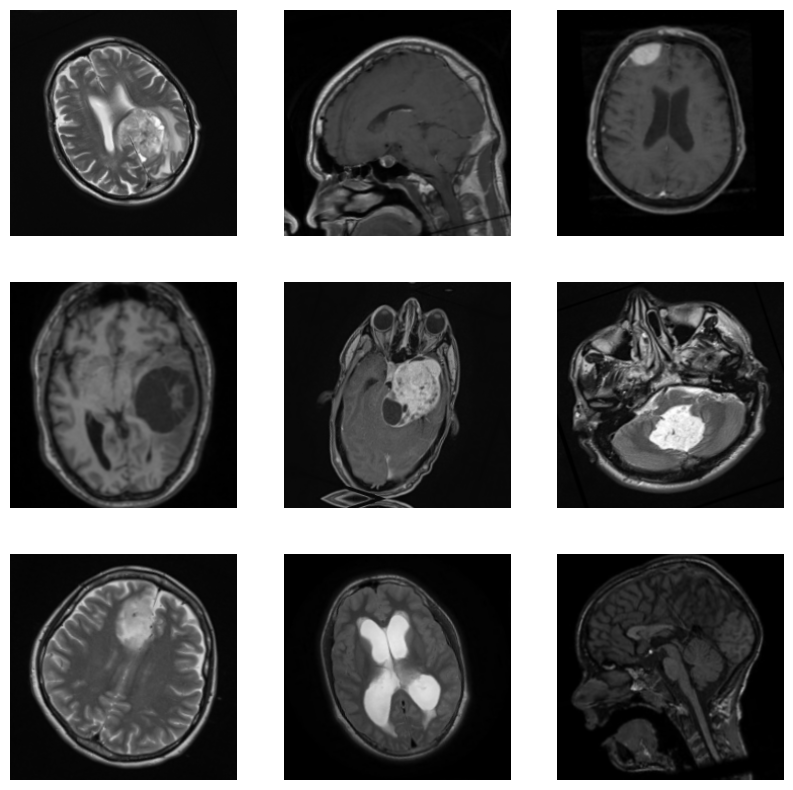

In [ ]:
# Visualization

import matplotlib.pyplot as plt

for images, _ in train_dataset.take(1):  # Take one batch
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Displaying only 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')  # Squeeze for single channel
        plt.axis("off")
    plt.show()